# Evolution


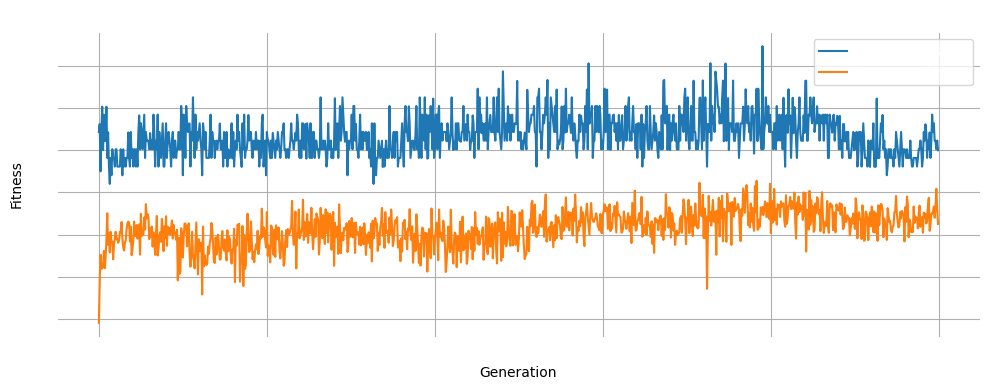

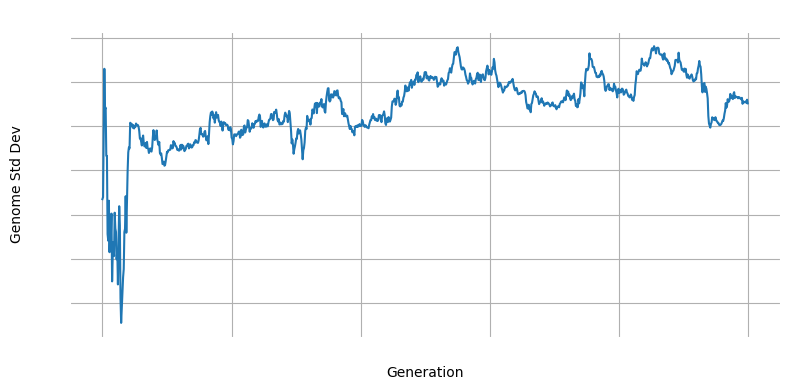

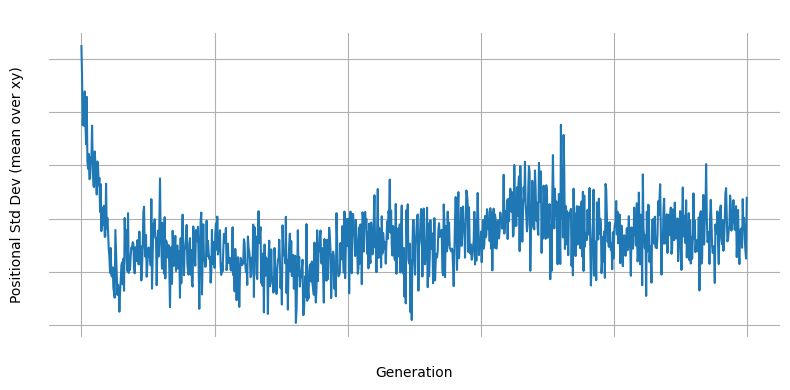

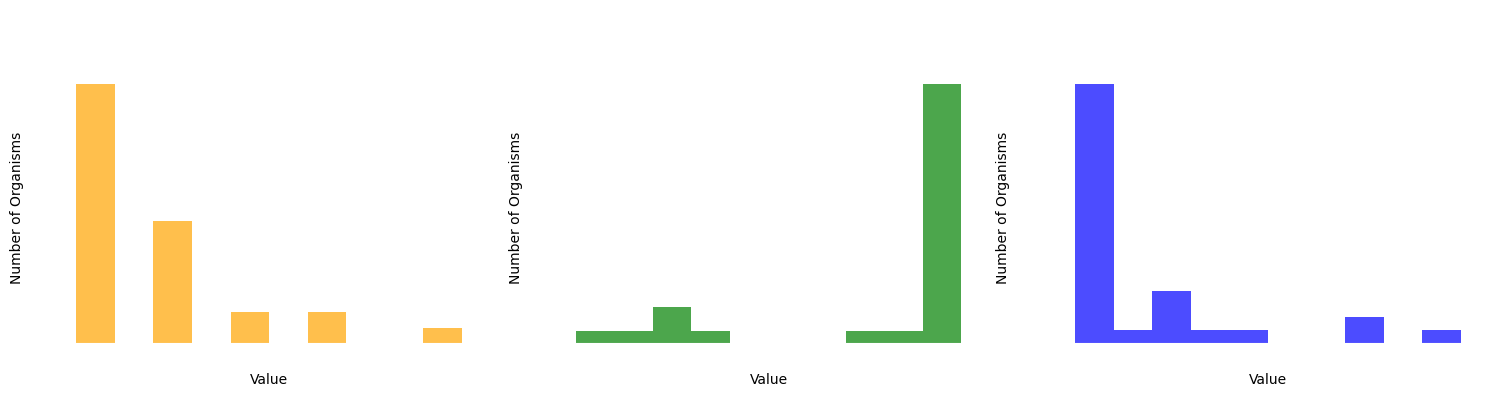

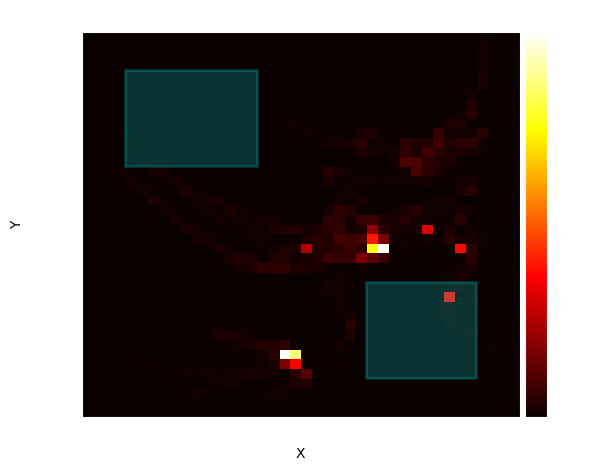

First generation:


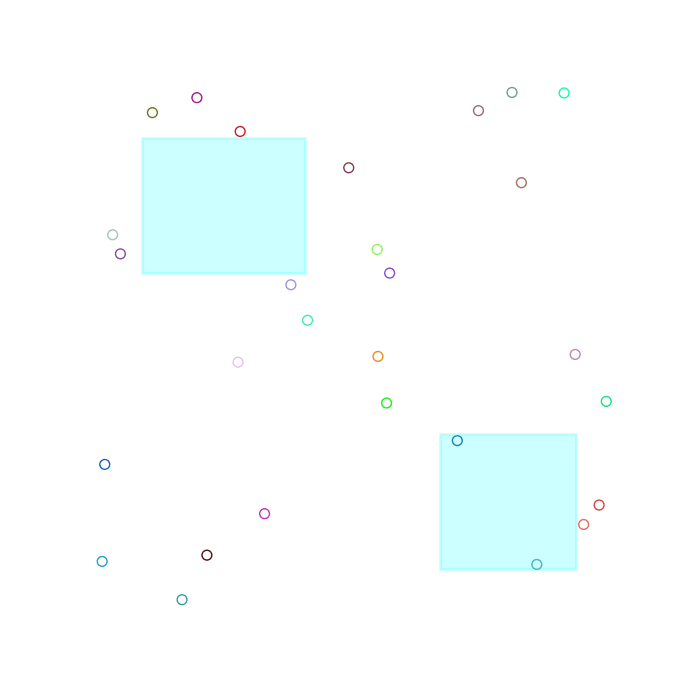

Last generation:


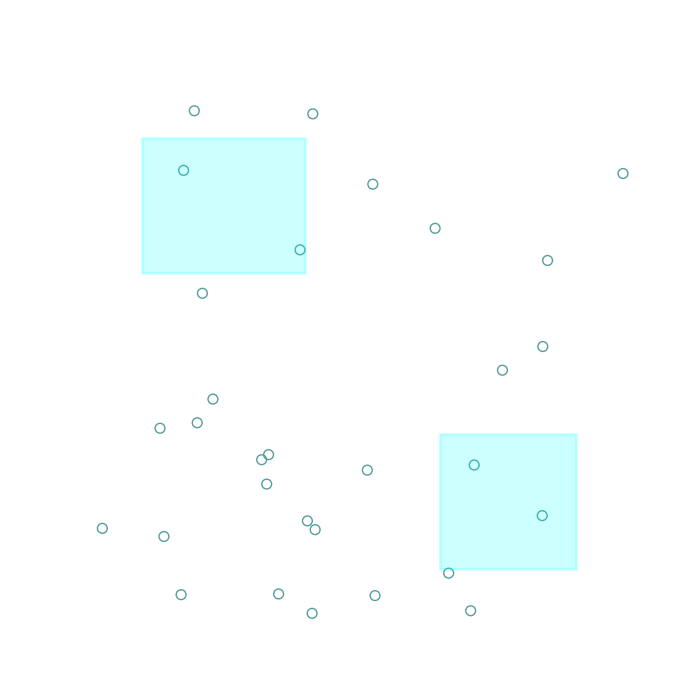

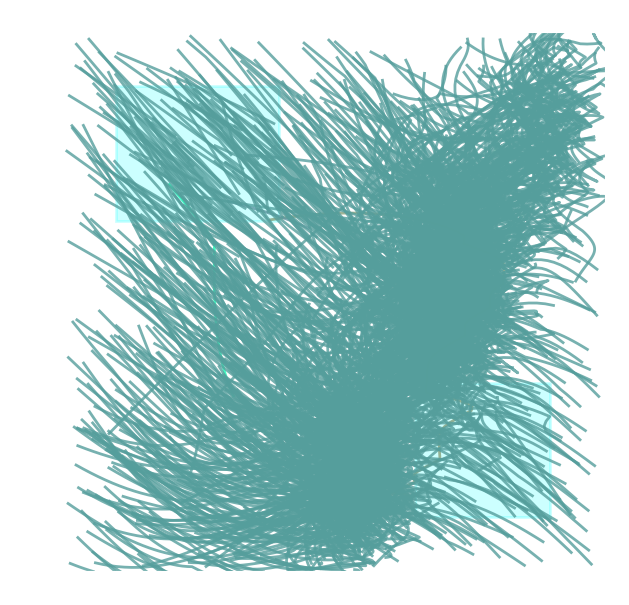

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- PARAMETERS ---
POP_SIZE = 30
LIFETIME = 100
NUM_GENERATIONS = 1000
ENV_SIZE = 10
NUM_FOOD_PATCHES = 3
FOOD_PER_PATCH = 5
FOOD_RADIUS = 0.7
MOVE_SCALE = 0.4
input_size = 4   # [x, y, dx_to_food, dy_to_food]
output_size = 2  # [dx, dy]
hazard_zones = [((-8, -2), (3, 8)), ((3, 8), (-8, -3))]  # [(x_range, y_range), ...]

# --- FITNESS WEIGHTS ---
alpha = 1.0   # food eaten importance
beta = 0.25   # survival time importance
gamma = 0.1   # energy left importance

# --- GENOME/NN UTILS ---
def create_random_genome(input_size, output_size):
    genome_size = input_size * output_size + output_size + output_size  # w, b, output scaling
    return np.random.randn(genome_size)

class NeuralNetwork:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.genome_size = input_size * output_size + output_size + output_size
        self.set_weights_from_genome(np.random.randn(self.genome_size))

    def set_weights_from_genome(self, genome):
        idx = 0
        self.w = genome[idx:idx+self.input_size*self.output_size].reshape((self.input_size, self.output_size))
        idx += self.input_size*self.output_size
        self.b = genome[idx:idx+self.output_size]
        idx += self.output_size
        self.out_scale = np.abs(genome[idx:idx+self.output_size]) + 0.2  # Ensure outputs have enough effect

    def forward(self, x):
        out = np.tanh(np.dot(x, self.w) + self.b) * self.out_scale
        return out

# --- COLOR UTIL ---
def blend_colors(c1, c2):
    # Blend as mean in RGB space
    return tuple(np.clip((np.array(c1) + np.array(c2)) / 2, 0, 1))

# --- ORGANISM ---
class Organism:
    def __init__(self, input_size=input_size, output_size=output_size, color=None):
        self.genome = create_random_genome(input_size, output_size)
        self.nn = NeuralNetwork(input_size, output_size)
        self.nn.set_weights_from_genome(self.genome)
        self.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        self.energy = 1.0
        self.alive = True
        self.food_eaten = 0
        self.survival_time = 0
        self.fitness = 0.0
        self.color = color if color is not None else tuple(np.random.rand(3))

# --- FOOD PATCHES + GRADIENT ---
def generate_food_patches(num_patches, food_per_patch, env_size):
    # Place food patches at random (x, y) but all on the right side (gradient)
    xs = np.linspace(env_size*0.2, env_size*0.9, num_patches)
    ys = np.linspace(-env_size*0.8, env_size*0.8, num_patches)
    food = []
    for cx, cy in zip(xs, ys):
        for _ in range(food_per_patch):
            point = np.array([
                np.random.normal(cx, env_size*0.1),
                np.random.normal(cy, env_size*0.9/num_patches)
            ])
            food.append(point)
    return np.array(food)

# --- HAZARD UTILS ---
def is_in_hazard(pos):
    for xr, yr in hazard_zones:
        if xr[0] <= pos[0] <= xr[1] and yr[0] <= pos[1] <= yr[1]:
            return True
    return False

# --- SIMULATION (for fitness, no recording) ---
def run_simulation_with_fitness(population):
    food_positions = generate_food_patches(NUM_FOOD_PATCHES, FOOD_PER_PATCH, ENV_SIZE)
    for organism in population:
        organism.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        organism.energy = 1.0
        organism.alive = True
        organism.food_eaten = 0
        organism.survival_time = 0
        organism.fitness = 0.0
        for step in range(LIFETIME):
            if not organism.alive:
                break
            organism.survival_time += 1
            # Find nearest food
            dists = np.linalg.norm(food_positions - organism.position, axis=1)
            nearest_idx = np.argmin(dists)
            nearest_food = food_positions[nearest_idx]
            direction_to_food = nearest_food - organism.position
            direction_to_food = direction_to_food / (np.linalg.norm(direction_to_food) + 1e-8)
            input_vec = np.concatenate([
                organism.position / ENV_SIZE,
                direction_to_food
            ])
            output = organism.nn.forward(input_vec)
            move = output * MOVE_SCALE
            organism.position += move
            organism.energy -= 0.01 + np.linalg.norm(move) * 0.01
            if is_in_hazard(organism.position):
                organism.energy -= 0.04  # Extra penalty in hazard zone
            # Try to eat if close to food
            if dists[nearest_idx] < FOOD_RADIUS:
                organism.energy += 0.25
                organism.food_eaten += 1
                food_positions[nearest_idx] = np.random.uniform(
                    ENV_SIZE*0.2, ENV_SIZE*0.9, size=1
                )[0], np.random.uniform(-ENV_SIZE*0.8, ENV_SIZE*0.8, size=1)[0]
            if organism.energy <= 0 or np.any(np.abs(organism.position) > ENV_SIZE):
                organism.alive = False
        organism.fitness = (
            alpha * organism.food_eaten +
            beta * organism.survival_time +
            gamma * organism.energy
        )
    return population

# --- SIMULATION (for animation, records positions for all agents) ---
def run_simulation_with_positions(population):
    N = len(population)
    positions = np.zeros((LIFETIME, N, 2))
    food_positions = generate_food_patches(NUM_FOOD_PATCHES, FOOD_PER_PATCH, ENV_SIZE)
    for organism in population:
        organism.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        organism.energy = 1.0
        organism.alive = True
        organism.food_eaten = 0
        organism.survival_time = 0
        organism.fitness = 0.0
    for step in range(LIFETIME):
        for idx, organism in enumerate(population):
            if not organism.alive:
                positions[step, idx, :] = organism.position
                continue
            organism.survival_time += 1
            dists = np.linalg.norm(food_positions - organism.position, axis=1)
            nearest_idx = np.argmin(dists)
            nearest_food = food_positions[nearest_idx]
            direction_to_food = nearest_food - organism.position
            direction_to_food = direction_to_food / (np.linalg.norm(direction_to_food) + 1e-8)
            input_vec = np.concatenate([
                organism.position / ENV_SIZE,
                direction_to_food
            ])
            output = organism.nn.forward(input_vec)
            move = output * MOVE_SCALE
            organism.position += move
            organism.energy -= 0.01 + np.linalg.norm(move) * 0.01
            if is_in_hazard(organism.position):
                organism.energy -= 0.04
            if dists[nearest_idx] < FOOD_RADIUS:
                organism.energy += 0.25
                organism.food_eaten += 1
                food_positions[nearest_idx] = np.random.uniform(
                    ENV_SIZE*0.2, ENV_SIZE*0.9, size=1
                )[0], np.random.uniform(-ENV_SIZE*0.8, ENV_SIZE*0.8, size=1)[0]
            if organism.energy <= 0 or np.any(np.abs(organism.position) > ENV_SIZE):
                organism.alive = False
            positions[step, idx, :] = organism.position
    return positions

# --- GENETIC OPERATORS ---
def select_parents_roulette_drift(population, num_offspring, drift_prob=0.04):
    fitnesses = np.array([org.fitness for org in population])
    total_fitness = fitnesses.sum()
    parents = []
    if total_fitness > 0:
        probabilities = fitnesses / total_fitness
    else:
        probabilities = np.full_like(fitnesses, 1/len(population))
    for _ in range(num_offspring):
        if np.random.rand() < drift_prob:
            idx = np.random.randint(0, len(population))
        else:
            idx = np.random.choice(len(population), p=probabilities)
        parents.append(idx)
    return parents

def uniform_crossover(genome1, genome2):
    mask = np.random.rand(len(genome1)) < 0.5
    child_genome = np.where(mask, genome1, genome2)
    return child_genome

def mutate(genome, mutation_rate=0.02, mutation_strength=0.1):
    mutation_mask = np.random.rand(len(genome)) < mutation_rate
    noise = np.random.normal(0, mutation_strength, size=genome.shape)
    mutated_genome = np.copy(genome)
    mutated_genome[mutation_mask] += noise[mutation_mask]
    return mutated_genome

def reproduce(population, parent_indices, parent_colors, energy_cost_per_child=0.15, mutation_rate=0.02, mutation_strength=0.1):
    new_population = []
    new_colors = []
    for _ in range(len(parent_indices)):
        idx1 = np.random.choice(parent_indices)
        idx2 = np.random.choice(parent_indices)
        parent1 = population[idx1]
        parent2 = population[idx2]
        child_genome = uniform_crossover(parent1.genome, parent2.genome)
        child_genome = mutate(child_genome, mutation_rate, mutation_strength)
        # Color blending
        child_color = blend_colors(parent_colors[idx1], parent_colors[idx2])
        child = Organism(input_size, output_size, color=child_color)
        child.genome = child_genome
        child.nn.set_weights_from_genome(child_genome)
        new_population.append(child)
        new_colors.append(child_color)
        parent1.energy -= energy_cost_per_child / 2
        parent2.energy -= energy_cost_per_child / 2
    return new_population, new_colors

# --- INITIAL POPULATION ---
lineage_colors = [tuple(np.random.rand(3)) for _ in range(POP_SIZE)]
population = [Organism(input_size, output_size, color=lineage_colors[i]) for i in range(POP_SIZE)]

# --- TRACKERS FOR ANALYSIS ---
best_fitness_per_gen = []
avg_fitness_per_gen = []
food_eaten_per_gen = []
survival_time_per_gen = []
energy_left_per_gen = []
genome_std_per_gen = []
final_position_std_per_gen = []
all_generations = []  # for replay (genomes, colors)
best_genomes = []
best_colors = []

# --- EVOLUTIONARY LOOP ---
for generation in range(NUM_GENERATIONS):
    population = run_simulation_with_fitness(population)
    # Per-gen tracking
    fitnesses = [org.fitness for org in population]
    best_idx = np.argmax(fitnesses)
    best_fitness_per_gen.append(np.max(fitnesses))
    avg_fitness_per_gen.append(np.mean(fitnesses))
    food_eaten_per_gen.append([org.food_eaten for org in population])
    survival_time_per_gen.append([org.survival_time for org in population])
    energy_left_per_gen.append([org.energy for org in population])
    genomes = np.array([org.genome for org in population])
    genome_std_per_gen.append(np.std(genomes))
    positions = np.array([org.position for org in population])
    final_position_std_per_gen.append(np.mean(np.std(positions, axis=0)))
    # Save all genomes and colors
    all_generations.append((
        [org.genome.copy() for org in population],
        [org.color for org in population]
    ))
    # Save best organism for replay
    best_genomes.append(population[best_idx].genome.copy())
    best_colors.append(population[best_idx].color)
    # Evolve
    parent_indices = select_parents_roulette_drift(population, len(population), drift_prob=0.04)
    population, lineage_colors = reproduce(population, parent_indices, lineage_colors, energy_cost_per_child=0.15, mutation_rate=0.02, mutation_strength=0.1)

# --- PLOTS ---

# Fitness curves
plt.figure(figsize=(10, 4))
plt.plot(best_fitness_per_gen, label="Best Fitness")
plt.plot(avg_fitness_per_gen, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Evolution Over Generations")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Genome diversity
plt.figure(figsize=(8,4))
plt.plot(genome_std_per_gen)
plt.xlabel("Generation")
plt.ylabel("Genome Std Dev")
plt.title("Genome Diversity (Std Dev of Genes) Over Generations")
plt.grid(True)
plt.tight_layout()
plt.show()

# Behavioral diversity (final positions)
plt.figure(figsize=(8,4))
plt.plot(final_position_std_per_gen)
plt.xlabel("Generation")
plt.ylabel("Positional Std Dev (mean over xy)")
plt.title("Behavioral Diversity (Final Position Spread) Over Generations")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograms for last generation metrics
gen_to_plot = -1
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(food_eaten_per_gen[gen_to_plot], bins=10, color='orange', alpha=0.7)
axs[0].set_title("Food Eaten")
axs[1].hist(survival_time_per_gen[gen_to_plot], bins=10, color='green', alpha=0.7)
axs[1].set_title("Survival Time")
axs[2].hist(energy_left_per_gen[gen_to_plot], bins=10, color='blue', alpha=0.7)
axs[2].set_title("Energy Left")
for ax in axs: ax.set_xlabel("Value"); ax.set_ylabel("Number of Organisms")
plt.suptitle(f"Distribution of Metrics: Generation {gen_to_plot if gen_to_plot >= 0 else len(food_eaten_per_gen) - 1}")
plt.tight_layout(); plt.show()

# --- BEHAVIORAL HEATMAP FOR LAST GENERATION ---
# Simulate last generation and accumulate positions
chosen_genomes, chosen_colors = all_generations[-1]
population = []
for genome, color in zip(chosen_genomes, chosen_colors):
    org = Organism(input_size, output_size, color=color)
    org.genome = genome.copy()
    org.nn.set_weights_from_genome(org.genome)
    population.append(org)
positions = run_simulation_with_positions(population)  # shape: (LIFETIME, POP_SIZE, 2)
all_pos = positions.reshape(-1, 2)
heatmap, xedges, yedges = np.histogram2d(all_pos[:,0], all_pos[:,1], bins=40, range=[[-ENV_SIZE, ENV_SIZE], [-ENV_SIZE, ENV_SIZE]])

plt.figure(figsize=(6,5))
plt.title("Behavioral Heatmap: All Positions Visited (Last Gen)")
plt.xlabel("X")
plt.ylabel("Y")
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
h = ax.imshow(
    heatmap.T, origin='lower',
    extent=[-ENV_SIZE, ENV_SIZE, -ENV_SIZE, ENV_SIZE],
    aspect='auto', cmap='hot'
)
plt.colorbar(h, cax=cax)
# Draw food gradient region and hazard zones
for xr, yr in hazard_zones:
    rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='cyan', alpha=0.2, lw=2, fill=True, label="Hazard")
    ax.add_patch(rect)
plt.show()

# --- ANIMATION: FULL POPULATION COLOR BY LINEAGE (LAST & FIRST GEN) ---
def animate_generation(gen_idx, filename):
    chosen_genomes, chosen_colors = all_generations[gen_idx]
    population = []
    for genome, color in zip(chosen_genomes, chosen_colors):
        org = Organism(input_size, output_size, color=color)
        org.genome = genome.copy()
        org.nn.set_weights_from_genome(org.genome)
        population.append(org)
    positions = run_simulation_with_positions(population)
    colors = np.array([color for color in chosen_colors])
    fig, ax = plt.subplots(figsize=(7,7))
    scat = ax.scatter([], [], c=[], s=50)
    ax.set_xlim(-ENV_SIZE, ENV_SIZE)
    ax.set_ylim(-ENV_SIZE, ENV_SIZE)
    ax.set_title(f"Population Animation (Generation {gen_idx+1})")
    # Draw food gradient region and hazard zones
    for xr, yr in hazard_zones:
        rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='cyan', alpha=0.2, lw=2, fill=True, label="Hazard")
        ax.add_patch(rect)
    def update(t):
        scat.set_offsets(positions[t])
        scat.set_color(colors)
        ax.set_title(f"Generation {gen_idx+1}, Frame {t}")
        return scat,
    ani = FuncAnimation(fig, update, frames=LIFETIME, interval=50)
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.close(fig)

# Animate first and last generation for comparison
animate_generation(0, 'pop_gen1.gif')
animate_generation(-1, f'pop_gen{NUM_GENERATIONS}.gif')

from IPython.display import Image, display
print("First generation:")
display(Image(filename='pop_gen1.gif'))
print("Last generation:")
display(Image(filename=f'pop_gen{NUM_GENERATIONS}.gif'))

# --- REPLAY BEST AGENT PER GENERATION ---
def animate_best_agents(best_genomes, best_colors):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_xlim(-ENV_SIZE, ENV_SIZE)
    ax.set_ylim(-ENV_SIZE, ENV_SIZE)
    ax.set_title("Best Organism Replay: Evolutionary Progression")
    for xr, yr in hazard_zones:
        rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='cyan', alpha=0.2, lw=2, fill=True, label="Hazard")
        ax.add_patch(rect)
    for gi, (genome, color) in enumerate(zip(best_genomes, best_colors)):
        org = Organism(input_size, output_size, color=color)
        org.genome = genome.copy()
        org.nn.set_weights_from_genome(genome)
        population = [org]
        positions = run_simulation_with_positions(population)  # shape: (LIFETIME, 1, 2)
        trail = positions[:,0,:]
        ax.plot(trail[:,0], trail[:,1], color=color, alpha=0.8, lw=2)
    plt.show()

animate_best_agents(best_genomes, best_colors)

# evo with obstacles and prey

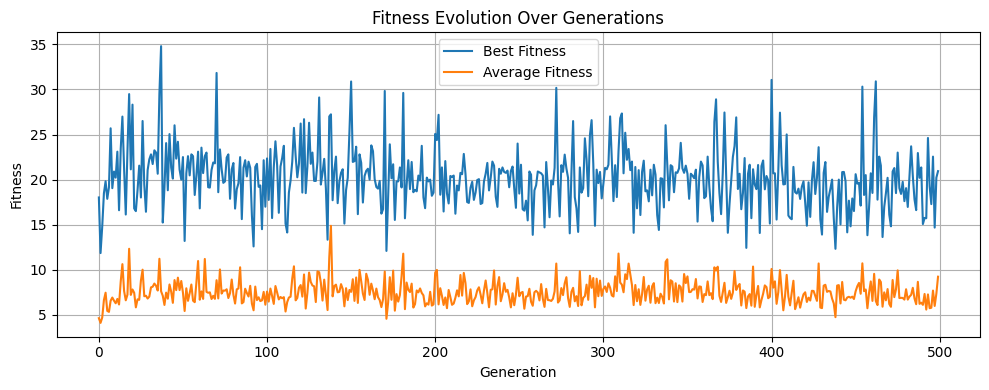

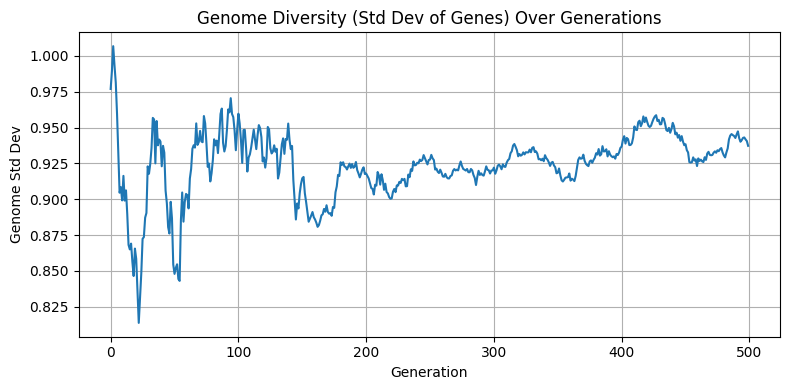

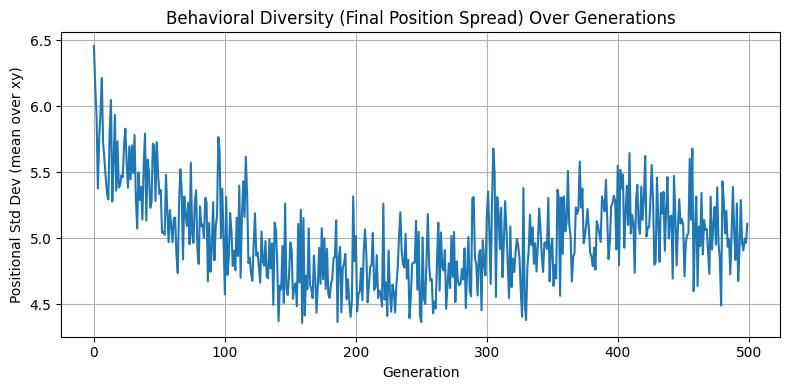

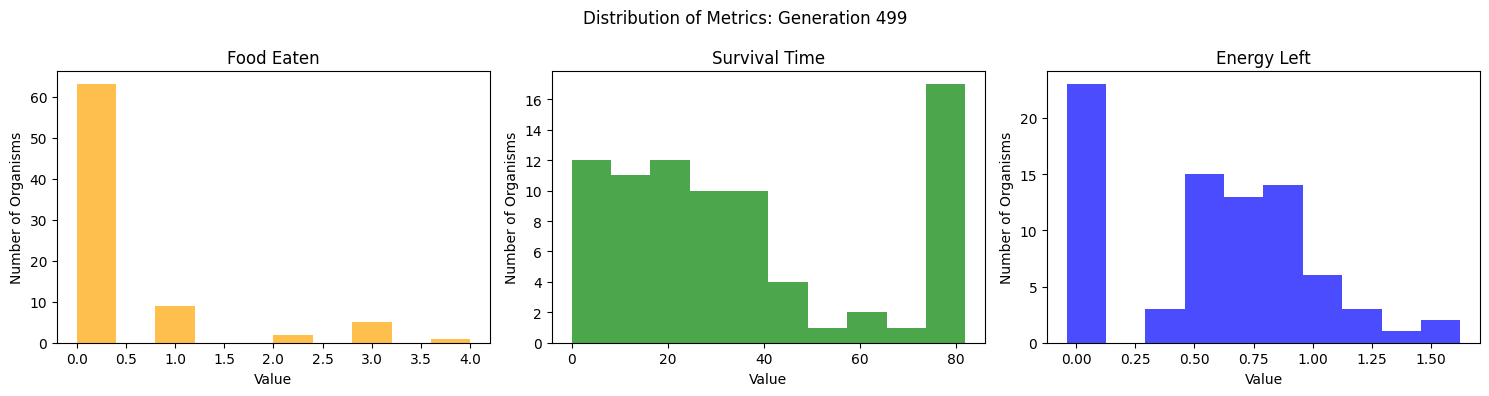

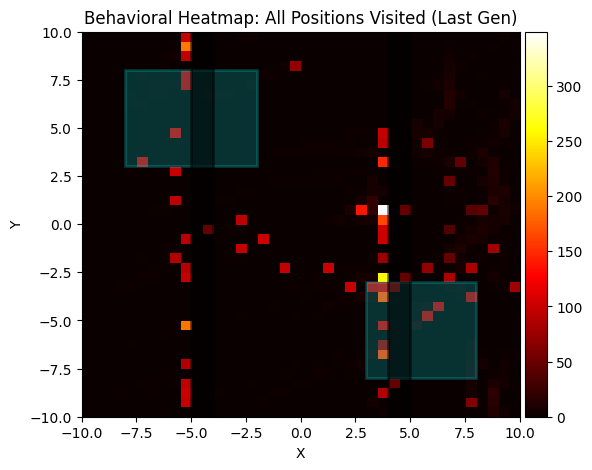

First generation:


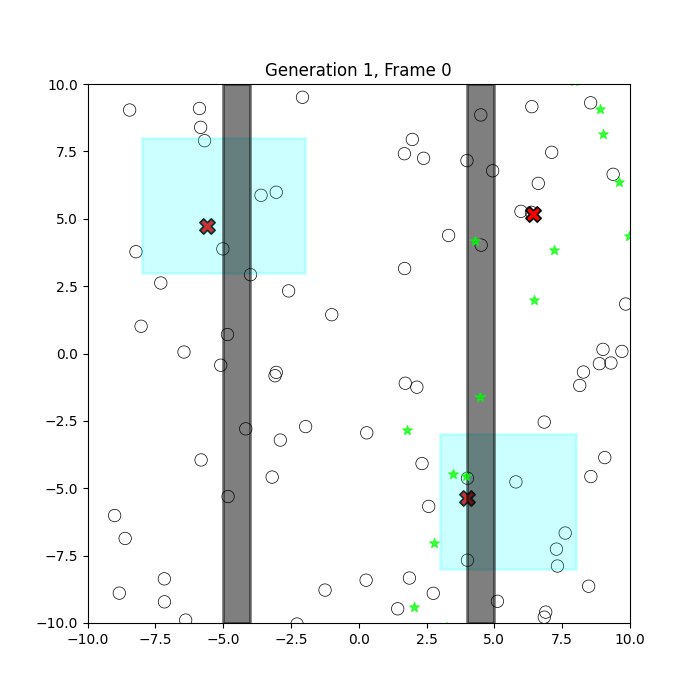

Last generation:


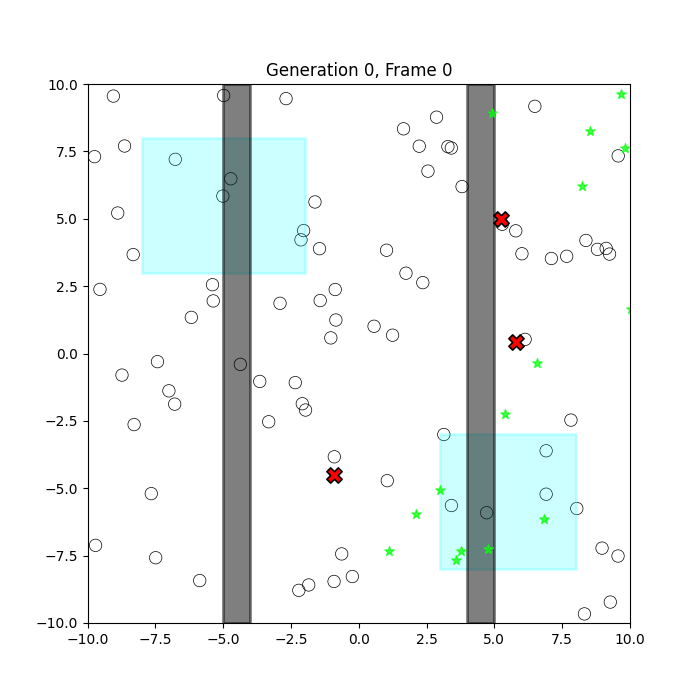

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- PARAMETERS ---
POP_SIZE = 80
LIFETIME = 100
NUM_GENERATIONS = 500
ENV_SIZE = 10
NUM_FOOD_PATCHES = 3
FOOD_PER_PATCH = 5
FOOD_RADIUS = 0.7
MOVE_SCALE = 0.4
NUM_PREDATORS = 3
PREDATOR_SPEED = 0.5
input_size = 6   # [x, y, dx_to_food, dy_to_food, nearby_count, avg_signal]
output_size = 3  # [dx, dy, signal]
hazard_zones = [((-8, -2), (3, 8)), ((3, 8), (-8, -3))]  # [(x_range, y_range), ...]
obstacle_zones = [((-5, -4), (-10, 10)), ((4, 5), (-10, 10))]  # vertical walls

# --- FITNESS WEIGHTS ---
alpha = 1.0   # food eaten importance
beta = 0.25   # survival time importance
gamma = 0.1   # energy left importance
delta = 0.5   # reward for being near kin
epsilon = 1.0 # penalty if caught by predator

# --- GENOME/NN UTILS ---
def create_random_genome(input_size, output_size):
    genome_size = input_size * output_size + output_size + output_size  # w, b, output scaling
    return np.random.randn(genome_size)

class NeuralNetwork:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.genome_size = input_size * output_size + output_size + output_size
        self.set_weights_from_genome(np.random.randn(self.genome_size))

    def set_weights_from_genome(self, genome):
        idx = 0
        self.w = genome[idx:idx+self.input_size*self.output_size].reshape((self.input_size, self.output_size))
        idx += self.input_size*self.output_size
        self.b = genome[idx:idx+self.output_size]
        idx += self.output_size
        self.out_scale = np.abs(genome[idx:idx+self.output_size]) + 0.2

    def forward(self, x):
        out = np.tanh(np.dot(x, self.w) + self.b) * self.out_scale
        return out

# --- COLOR UTIL ---
def blend_colors(c1, c2):
    return tuple(np.clip((np.array(c1) + np.array(c2)) / 2, 0, 1))

# --- ORGANISM ---
class Organism:
    def __init__(self, input_size=input_size, output_size=output_size, color=None):
        self.genome = create_random_genome(input_size, output_size)
        self.nn = NeuralNetwork(input_size, output_size)
        self.nn.set_weights_from_genome(self.genome)
        self.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        self.energy = 1.0
        self.alive = True
        self.food_eaten = 0
        self.survival_time = 0
        self.fitness = 0.0
        self.signal = 0.0
        self.color = color if color is not None else tuple(np.random.rand(3))
        self.caught_by_predator = False

# --- PREDATOR ---
class Predator:
    def __init__(self):
        self.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        self.speed = PREDATOR_SPEED

    def step(self, prey_positions):
        # Simple: move toward the nearest agent
        dists = np.linalg.norm(prey_positions - self.position, axis=1)
        if len(dists) == 0:
            return
        nearest_idx = np.argmin(dists)
        direction = prey_positions[nearest_idx] - self.position
        dist = np.linalg.norm(direction)
        if dist > 1e-6:
            direction = direction / dist
            self.position += direction * self.speed
            self.position = np.clip(self.position, -ENV_SIZE, ENV_SIZE)

# --- FOOD PATCHES + GRADIENT ---
def generate_food_patches(num_patches, food_per_patch, env_size):
    xs = np.linspace(env_size*0.2, env_size*0.9, num_patches)
    ys = np.linspace(-env_size*0.8, env_size*0.8, num_patches)
    food = []
    for cx, cy in zip(xs, ys):
        for _ in range(food_per_patch):
            point = np.array([
                np.random.normal(cx, env_size*0.1),
                np.random.normal(cy, env_size*0.9/num_patches)
            ])
            food.append(point)
    return np.array(food)

# --- HAZARD/OBSTACLE UTILS ---
def is_in_hazard(pos):
    for xr, yr in hazard_zones:
        if xr[0] <= pos[0] <= xr[1] and yr[0] <= pos[1] <= yr[1]:
            return True
    return False

def is_in_obstacle(pos):
    for xr, yr in obstacle_zones:
        if xr[0] <= pos[0] <= xr[1] and yr[0] <= pos[1] <= yr[1]:
            return True
    return False

def move_with_obstacles(pos, move):
    # Try to move, if would enter obstacle, stop at the border
    new_pos = pos + move
    for xr, yr in obstacle_zones:
        if xr[0] < new_pos[0] < xr[1] and yr[0] < new_pos[1] < yr[1]:
            # Block movement in x direction
            if pos[0] < xr[0]: new_pos[0] = xr[0] - 0.01
            elif pos[0] > xr[1]: new_pos[0] = xr[1] + 0.01
            else: new_pos[0] = pos[0]
            # Block movement in y direction
            if pos[1] < yr[0]: new_pos[1] = yr[0] - 0.01
            elif pos[1] > yr[1]: new_pos[1] = yr[1] + 0.01
            else: new_pos[1] = pos[1]
    return new_pos

# --- SOCIETY SENSING ---
def get_proximity_and_signal(organism, population, radius=2.5):
    # Count and mean signal of agents within radius (excluding self)
    deltas = np.array([other.position - organism.position for other in population])
    dists = np.linalg.norm(deltas, axis=1)
    mask = (dists < radius) & (dists > 0.01)
    nearby = [population[i] for i in range(len(population)) if mask[i]]
    kin_count = 0
    avg_signal = 0.0
    if nearby:
        # kin: color distance less than 0.3
        kin_count = sum(np.linalg.norm(np.array(organism.color) - np.array(n.color)) < 0.3 for n in nearby)
        avg_signal = np.mean([n.signal for n in nearby])
    return len(nearby), kin_count, avg_signal

# --- SIMULATION (FITNESS & SIGNALS) ---
def run_simulation_with_fitness(population):
    food_positions = generate_food_patches(NUM_FOOD_PATCHES, FOOD_PER_PATCH, ENV_SIZE)
    predators = [Predator() for _ in range(NUM_PREDATORS)]
    for organism in population:
        organism.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        organism.energy = 1.0
        organism.alive = True
        organism.food_eaten = 0
        organism.survival_time = 0
        organism.fitness = 0.0
        organism.signal = 0.0
        organism.caught_by_predator = False
    for step in range(LIFETIME):
        # Predator step: move toward nearest alive prey
        prey_positions = np.array([org.position for org in population if org.alive])
        for pred in predators:
            if len(prey_positions) > 0:
                pred.step(prey_positions)
        # Organisms step
        for organism in population:
            if not organism.alive: continue
            # Predator check
            for pred in predators:
                if np.linalg.norm(pred.position - organism.position) < 0.7:
                    organism.alive = False
                    organism.caught_by_predator = True
                    break
            if not organism.alive: continue
            organism.survival_time += 1
            dists = np.linalg.norm(food_positions - organism.position, axis=1)
            nearest_idx = np.argmin(dists)
            nearest_food = food_positions[nearest_idx]
            direction_to_food = nearest_food - organism.position
            direction_to_food = direction_to_food / (np.linalg.norm(direction_to_food) + 1e-8)
            nearby_count, kin_count, avg_signal = get_proximity_and_signal(organism, population)
            input_vec = np.concatenate([
                organism.position / ENV_SIZE,
                direction_to_food,
                [nearby_count/5.0], # normalize group input
                [avg_signal]
            ])
            output = organism.nn.forward(input_vec)
            move = output[:2] * MOVE_SCALE
            move = np.clip(move, -1, 1)
            # Try obstacle-aware move
            candidate_pos = move_with_obstacles(organism.position, move)
            organism.position = candidate_pos
            organism.signal = float(np.clip(output[2], -1, 1))
            organism.energy -= 0.01 + np.linalg.norm(move) * 0.01
            if is_in_hazard(organism.position):
                organism.energy -= 0.04
            # Try to eat if close to food
            if dists[nearest_idx] < FOOD_RADIUS:
                organism.energy += 0.25
                organism.food_eaten += 1
                food_positions[nearest_idx] = np.random.uniform(
                    ENV_SIZE*0.2, ENV_SIZE*0.9, size=1
                )[0], np.random.uniform(-ENV_SIZE*0.8, ENV_SIZE*0.8, size=1)[0]
            if organism.energy <= 0 or np.any(np.abs(organism.position) > ENV_SIZE):
                organism.alive = False
    for organism in population:
        # Reward for being near kin, penalty if caught by predator
        _, kin_count, _ = get_proximity_and_signal(organism, population)
        group_bonus = delta * (kin_count / 5.0)
        pred_penalty = epsilon if organism.caught_by_predator else 0.0
        organism.fitness = (
            alpha * organism.food_eaten +
            beta * organism.survival_time +
            gamma * organism.energy +
            group_bonus -
            pred_penalty
        )
    return population

# --- SIMULATION (for animation, records positions for all agents) ---
def run_simulation_with_positions(population):
    N = len(population)
    positions = np.zeros((LIFETIME, N, 2))
    signals = np.zeros((LIFETIME, N))
    food_positions = generate_food_patches(NUM_FOOD_PATCHES, FOOD_PER_PATCH, ENV_SIZE)
    predators = [Predator() for _ in range(NUM_PREDATORS)]
    for organism in population:
        organism.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, size=2)
        organism.energy = 1.0
        organism.alive = True
        organism.food_eaten = 0
        organism.survival_time = 0
        organism.fitness = 0.0
        organism.signal = 0.0
        organism.caught_by_predator = False
    for step in range(LIFETIME):
        prey_positions = np.array([org.position for org in population if org.alive])
        for pred in predators:
            if len(prey_positions) > 0:
                pred.step(prey_positions)
        for idx, organism in enumerate(population):
            if not organism.alive:
                positions[step, idx, :] = organism.position
                signals[step, idx] = organism.signal
                continue
            # Predator check
            for pred in predators:
                if np.linalg.norm(pred.position - organism.position) < 0.7:
                    organism.alive = False
                    organism.caught_by_predator = True
                    break
            if not organism.alive:
                positions[step, idx, :] = organism.position
                signals[step, idx] = organism.signal
                continue
            organism.survival_time += 1
            dists = np.linalg.norm(food_positions - organism.position, axis=1)
            nearest_idx = np.argmin(dists)
            nearest_food = food_positions[nearest_idx]
            direction_to_food = nearest_food - organism.position
            direction_to_food = direction_to_food / (np.linalg.norm(direction_to_food) + 1e-8)
            nearby_count, kin_count, avg_signal = get_proximity_and_signal(organism, population)
            input_vec = np.concatenate([
                organism.position / ENV_SIZE,
                direction_to_food,
                [nearby_count/5.0],
                [avg_signal]
            ])
            output = organism.nn.forward(input_vec)
            move = output[:2] * MOVE_SCALE
            move = np.clip(move, -1, 1)
            candidate_pos = move_with_obstacles(organism.position, move)
            organism.position = candidate_pos
            organism.signal = float(np.clip(output[2], -1, 1))
            organism.energy -= 0.01 + np.linalg.norm(move) * 0.01
            if is_in_hazard(organism.position):
                organism.energy -= 0.04
            if dists[nearest_idx] < FOOD_RADIUS:
                organism.energy += 0.25
                organism.food_eaten += 1
                food_positions[nearest_idx] = np.random.uniform(
                    ENV_SIZE*0.2, ENV_SIZE*0.9, size=1
                )[0], np.random.uniform(-ENV_SIZE*0.8, ENV_SIZE*0.8, size=1)[0]
            if organism.energy <= 0 or np.any(np.abs(organism.position) > ENV_SIZE):
                organism.alive = False
            positions[step, idx, :] = organism.position
            signals[step, idx] = organism.signal
    return positions, signals

# --- GENETIC OPERATORS ---
def select_parents_roulette_drift(population, num_offspring, drift_prob=0.04):
    fitnesses = np.array([org.fitness for org in population])
    fitnesses = np.clip(fitnesses, a_min=0.0, a_max=None)
    total_fitness = fitnesses.sum()
    parents = []
    if total_fitness > 0:
        probabilities = fitnesses / total_fitness
    else:
        probabilities = np.full_like(fitnesses, 1/len(population))
    for _ in range(num_offspring):
        if np.random.rand() < drift_prob:
            idx = np.random.randint(0, len(population))
        else:
            idx = np.random.choice(len(population), p=probabilities)
        parents.append(idx)
    return parents

def uniform_crossover(genome1, genome2):
    mask = np.random.rand(len(genome1)) < 0.5
    child_genome = np.where(mask, genome1, genome2)
    return child_genome

def mutate(genome, mutation_rate=0.02, mutation_strength=0.1):
    mutation_mask = np.random.rand(len(genome)) < mutation_rate
    noise = np.random.normal(0, mutation_strength, size=genome.shape)
    mutated_genome = np.copy(genome)
    mutated_genome[mutation_mask] += noise[mutation_mask]
    return mutated_genome

def reproduce(population, parent_indices, parent_colors, energy_cost_per_child=0.15, mutation_rate=0.02, mutation_strength=0.1):
    new_population = []
    new_colors = []
    for _ in range(len(parent_indices)):
        idx1 = np.random.choice(parent_indices)
        idx2 = np.random.choice(parent_indices)
        parent1 = population[idx1]
        parent2 = population[idx2]
        child_genome = uniform_crossover(parent1.genome, parent2.genome)
        child_genome = mutate(child_genome, mutation_rate, mutation_strength)
        child_color = blend_colors(parent_colors[idx1], parent_colors[idx2])
        child = Organism(input_size, output_size, color=child_color)
        child.genome = child_genome
        child.nn.set_weights_from_genome(child_genome)
        new_population.append(child)
        new_colors.append(child_color)
        parent1.energy -= energy_cost_per_child / 2
        parent2.energy -= energy_cost_per_child / 2
    return new_population, new_colors

# --- INITIAL POPULATION ---
lineage_colors = [tuple(np.random.rand(3)) for _ in range(POP_SIZE)]
population = [Organism(input_size, output_size, color=lineage_colors[i]) for i in range(POP_SIZE)]

# --- TRACKERS FOR ANALYSIS ---
best_fitness_per_gen = []
avg_fitness_per_gen = []
food_eaten_per_gen = []
survival_time_per_gen = []
energy_left_per_gen = []
genome_std_per_gen = []
final_position_std_per_gen = []
all_generations = []  # for replay (genomes, colors)

# --- EVOLUTIONARY LOOP ---
for generation in range(NUM_GENERATIONS):
    population = run_simulation_with_fitness(population)
    fitnesses = [org.fitness for org in population]
    best_fitness_per_gen.append(np.max(fitnesses))
    avg_fitness_per_gen.append(np.mean(fitnesses))
    food_eaten_per_gen.append([org.food_eaten for org in population])
    survival_time_per_gen.append([org.survival_time for org in population])
    energy_left_per_gen.append([org.energy for org in population])
    genomes = np.array([org.genome for org in population])
    genome_std_per_gen.append(np.std(genomes))
    positions = np.array([org.position for org in population])
    final_position_std_per_gen.append(np.mean(np.std(positions, axis=0)))
    all_generations.append((
        [org.genome.copy() for org in population],
        [org.color for org in population]
    ))
    parent_indices = select_parents_roulette_drift(population, len(population), drift_prob=0.04)
    population, lineage_colors = reproduce(population, parent_indices, lineage_colors, energy_cost_per_child=0.15, mutation_rate=0.02, mutation_strength=0.1)

# --- PLOTS ---

plt.figure(figsize=(10, 4))
plt.plot(best_fitness_per_gen, label="Best Fitness")
plt.plot(avg_fitness_per_gen, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Evolution Over Generations")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(genome_std_per_gen)
plt.xlabel("Generation")
plt.ylabel("Genome Std Dev")
plt.title("Genome Diversity (Std Dev of Genes) Over Generations")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(final_position_std_per_gen)
plt.xlabel("Generation")
plt.ylabel("Positional Std Dev (mean over xy)")
plt.title("Behavioral Diversity (Final Position Spread) Over Generations")
plt.grid(True)
plt.tight_layout()
plt.show()

gen_to_plot = -1
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(food_eaten_per_gen[gen_to_plot], bins=10, color='orange', alpha=0.7)
axs[0].set_title("Food Eaten")
axs[1].hist(survival_time_per_gen[gen_to_plot], bins=10, color='green', alpha=0.7)
axs[1].set_title("Survival Time")
axs[2].hist(energy_left_per_gen[gen_to_plot], bins=10, color='blue', alpha=0.7)
axs[2].set_title("Energy Left")
for ax in axs: ax.set_xlabel("Value"); ax.set_ylabel("Number of Organisms")
plt.suptitle(f"Distribution of Metrics: Generation {gen_to_plot if gen_to_plot >= 0 else len(food_eaten_per_gen) - 1}")
plt.tight_layout(); plt.show()

# --- BEHAVIORAL HEATMAP ---
chosen_genomes, chosen_colors = all_generations[-1]
population = []
for genome, color in zip(chosen_genomes, chosen_colors):
    org = Organism(input_size, output_size, color=color)
    org.genome = genome.copy()
    org.nn.set_weights_from_genome(org.genome)
    population.append(org)
positions, signals = run_simulation_with_positions(population)
all_pos = positions.reshape(-1, 2)
heatmap, xedges, yedges = np.histogram2d(all_pos[:,0], all_pos[:,1], bins=40, range=[[-ENV_SIZE, ENV_SIZE], [-ENV_SIZE, ENV_SIZE]])

plt.figure(figsize=(6,5))
plt.title("Behavioral Heatmap: All Positions Visited (Last Gen)")
plt.xlabel("X")
plt.ylabel("Y")
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
h = ax.imshow(
    heatmap.T, origin='lower',
    extent=[-ENV_SIZE, ENV_SIZE, -ENV_SIZE, ENV_SIZE],
    aspect='auto', cmap='hot'
)
plt.colorbar(h, cax=cax)
for xr, yr in hazard_zones:
    rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='cyan', alpha=0.2, lw=2, fill=True, label="Hazard")
    ax.add_patch(rect)
for xr, yr in obstacle_zones:
    rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='black', alpha=0.5, lw=2, fill=True, label="Obstacle")
    ax.add_patch(rect)
plt.show()

# --- ANIMATION: COLOR BY LINEAGE (FILLED) + PREDATORS + OBSTACLES ---
def animate_generation(gen_idx, filename):
    chosen_genomes, chosen_colors = all_generations[gen_idx]
    population = []
    for genome, color in zip(chosen_genomes, chosen_colors):
        org = Organism(input_size, output_size, color=color)
        org.genome = genome.copy()
        org.nn.set_weights_from_genome(org.genome)
        population.append(org)
    positions, signals = run_simulation_with_positions(population)
    colors = np.array([color for color in chosen_colors])
    fig, ax = plt.subplots(figsize=(7,7))
    scat = ax.scatter([], [], c=[], s=80, marker='o', edgecolors='k', linewidths=0.5)
    pred_scat = ax.scatter([], [], c='red', s=120, marker='X', edgecolors='k', linewidths=1.2)
    ax.set_xlim(-ENV_SIZE, ENV_SIZE)
    ax.set_ylim(-ENV_SIZE, ENV_SIZE)
    ax.set_title(f"Population Animation (Generation {gen_idx+1})")
    for xr, yr in hazard_zones:
        rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='cyan', alpha=0.2, lw=2, fill=True, label="Hazard")
        ax.add_patch(rect)
    for xr, yr in obstacle_zones:
        rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='black', alpha=0.5, lw=2, fill=True, label="Obstacle")
        ax.add_patch(rect)
    # Draw food (just static for display)
    food_positions = generate_food_patches(NUM_FOOD_PATCHES, FOOD_PER_PATCH, ENV_SIZE)
    ax.scatter(food_positions[:,0], food_positions[:,1], c='lime', s=50, marker='*', alpha=0.7, label="Food")
    # Animate predators
    predators = [Predator() for _ in range(NUM_PREDATORS)]
    pred_positions = np.zeros((LIFETIME, NUM_PREDATORS, 2))
    # Simulate predator positions
    for step in range(LIFETIME):
        prey_positions = positions[step]
        for pi, pred in enumerate(predators):
            if len(prey_positions) > 0:
                pred.step(prey_positions)
            pred_positions[step, pi, :] = pred.position
    def update(t):
        scat.set_offsets(positions[t])
        scat.set_facecolors(colors)
        pred_scat.set_offsets(pred_positions[t])
        ax.set_title(f"Generation {gen_idx+1}, Frame {t}")
        return scat, pred_scat
    ani = FuncAnimation(fig, update, frames=LIFETIME, interval=45)
    ani.save(filename, writer=PillowWriter(fps=20))
    plt.close(fig)

animate_generation(0, 'pop_gen1.gif')
animate_generation(-1, f'pop_gen{NUM_GENERATIONS}.gif')

from IPython.display import Image, display
print("First generation:")
display(Image(filename='pop_gen1.gif'))
print("Last generation:")
display(Image(filename=f'pop_gen{NUM_GENERATIONS}.gif'))

# Predator vs Prey

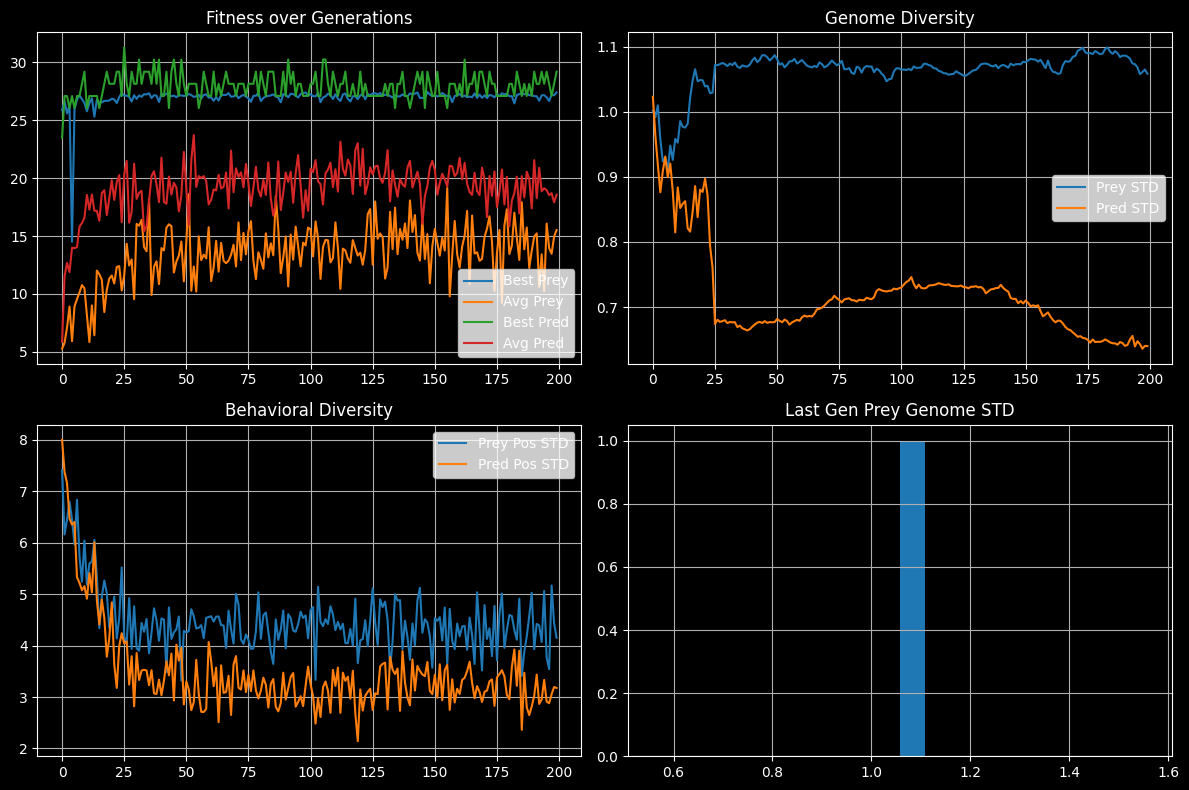

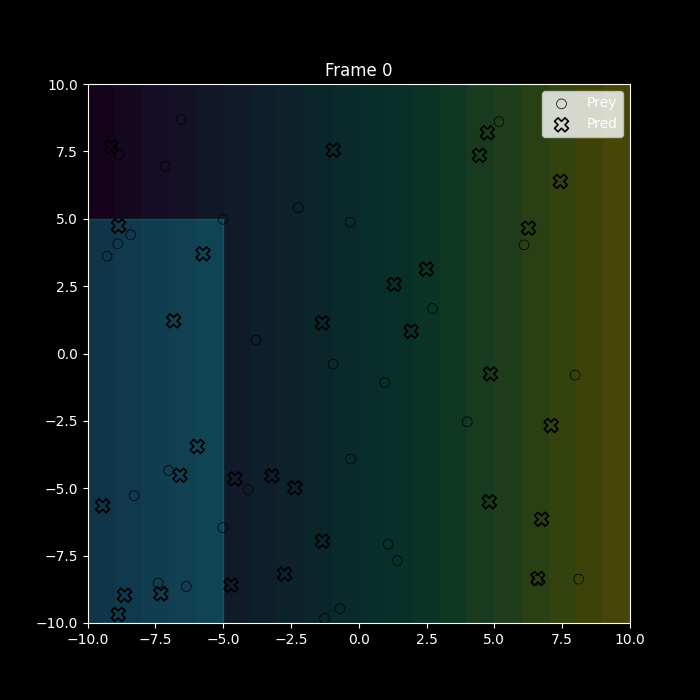

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- PARAMETERS ---
POP_SIZE = 30
LIFETIME = 100
NUM_GENERATIONS = 200
ENV_SIZE = 10
MOVE_SCALE = 0.4
input_size = 4   # [x_norm, y_norm, dx_to_food, dy_to_food]
output_size = 2  # [dx, dy]

# Hazard confined to left side
hazard_zones = [((-ENV_SIZE, -0.5 * ENV_SIZE), (-ENV_SIZE, 0.5 * ENV_SIZE))]

# --- FITNESS WEIGHTS ---
# Prey
alpha_prey = 1.0   # food importance
beta_prey = 0.25   # survival importance
gamma_prey = 0.1   # energy importance
# Predator
theta_pred = 1.0   # prey eaten importance
beta_pred = 0.25   # survival importance
gamma_pred = 0.1   # energy importance

# Energy gains
delta_food = 0.25
delta_pred_food = 0.5

# --- GENOME/NN UTILS ---
def create_random_genome(in_size, out_size):
    return np.random.randn(in_size * out_size + out_size + out_size)

class NeuralNetwork:
    def __init__(self, in_size, out_size):
        self.input_size = in_size
        self.output_size = out_size
        self.genome_size = in_size * out_size + out_size + out_size
        self.set_weights_from_genome(np.random.randn(self.genome_size))

    def set_weights_from_genome(self, genome):
        idx = 0
        self.w = genome[idx:idx + self.input_size*self.output_size] \
                    .reshape(self.input_size, self.output_size)
        idx += self.input_size*self.output_size
        self.b = genome[idx:idx + self.output_size]
        idx += self.output_size
        self.out_scale = np.abs(genome[idx:idx + self.output_size]) + 0.2

    def forward(self, x):
        return np.tanh(x.dot(self.w) + self.b) * self.out_scale

# --- COLOR UTIL ---
def blend_colors(c1, c2):
    return tuple(np.clip((np.array(c1) + np.array(c2)) / 2, 0, 1))

# --- AGENT CLASSES ---
class Agent:
    def __init__(self, in_size, out_size, color=None):
        self.genome = create_random_genome(in_size, out_size)
        self.nn = NeuralNetwork(in_size, out_size)
        self.nn.set_weights_from_genome(self.genome)
        self.position = np.random.uniform(-ENV_SIZE, ENV_SIZE, 2)
        self.energy = 1.0
        self.alive = True
        self.survival_time = 0
        self.fitness = 0.0
        self.color = color if color else tuple(np.random.rand(3))

    def step(self, food_density_field, prey_list=None):
        dir_to_food = np.array([1.0, 0.0])
        inp = np.concatenate([self.position / ENV_SIZE, dir_to_food])
        move = self.nn.forward(inp) * MOVE_SCALE
        self.position += move
        self.energy -= 0.01 + np.linalg.norm(move)*0.01
        for xr, yr in hazard_zones:
            if xr[0] <= self.position[0] <= xr[1] and yr[0] <= self.position[1] <= yr[1]:
                self.energy -= 0.04
        if prey_list is None:
            self.energy += food_density_field(self.position) * delta_food
        else:
            dists = [np.linalg.norm(p.position - self.position) for p in prey_list]
            idx = np.argmin(dists)
            if dists[idx] < 0.5 and prey_list[idx].alive:
                prey_list[idx].alive = False
                self.energy += delta_pred_food
                self.prey_eaten += 1
        if self.alive:
            self.survival_time += 1
        if self.energy <= 0 or np.any(np.abs(self.position) > ENV_SIZE):
            self.alive = False

class Prey(Agent):
    def __init__(self, in_size, out_size, color=None):
        super().__init__(in_size, out_size, color)
        self.food_eaten = 0

class Predator(Agent):
    def __init__(self, in_size, out_size, color=None):
        super().__init__(in_size, out_size, color)
        self.prey_eaten = 0

# --- FOOD DENSITY FIELD ---
def food_density_field(pos):
    return (pos[0] + ENV_SIZE) / (2*ENV_SIZE)

# --- GENETIC OPERATORS ---
def select_parents(pop, num_off):
    fits = np.array([a.fitness for a in pop])
    probs = fits / fits.sum() if fits.sum()>0 else np.ones_like(fits)/len(fits)
    return [np.random.choice(len(pop), p=probs) for _ in range(num_off)]

def uniform_crossover(g1, g2):
    mask = np.random.rand(len(g1)) < 0.5
    return np.where(mask, g1, g2)

def mutate(g, rate=0.02, strength=0.1):
    mask = np.random.rand(len(g))<rate
    g[mask] += np.random.randn(mask.sum())*strength
    return g

def reproduce(pop, parent_ids, colors):
    new_pop, new_cols = [], []
    for _ in parent_ids:
        i1, i2 = np.random.choice(parent_ids,2)
        g = mutate(uniform_crossover(pop[i1].genome, pop[i2].genome))
        c = blend_colors(colors[i1], colors[i2])
        child = type(pop[0])(input_size,output_size,color=c)
        child.genome, child.nn = g, NeuralNetwork(input_size,output_size)
        child.nn.set_weights_from_genome(g)
        new_pop.append(child); new_cols.append(c)
    return new_pop, new_cols

# --- DATA COLLECTION ---
prey_colors = [tuple(np.random.rand(3)) for _ in range(POP_SIZE)]
pred_colors = [tuple(np.random.rand(3)) for _ in range(POP_SIZE)]
prey_pop = [Prey(input_size, output_size, c) for c in prey_colors]
pred_pop = [Predator(input_size, output_size, c) for c in pred_colors]

best_prey, avg_prey = [], []
best_pred, avg_pred = [], []
std_preys, std_preds = [], []
pos_diversity_preys, pos_diversity_preds = [], []

# --- EVOLUTIONARY LOOP ---
for gen in range(NUM_GENERATIONS):
    for a in prey_pop+pred_pop:
        a.position=np.random.uniform(-ENV_SIZE,ENV_SIZE,2)
        a.energy=1.0; a.alive=True; a.survival_time=0
        if isinstance(a,Prey): a.food_eaten=0
        else: a.prey_eaten=0

    for t in range(LIFETIME):
        for prey in prey_pop:
            if prey.alive: prey.step(food_density_field)
        for pred in pred_pop:
            if pred.alive: pred.step(food_density_field, prey_pop)

    # Fitness
    for prey in prey_pop:
        prey.fitness = alpha_prey*prey.food_eaten + beta_prey*prey.survival_time + gamma_prey*prey.energy
    for pred in pred_pop:
        pred.fitness = theta_pred*pred.prey_eaten + beta_pred*pred.survival_time + gamma_pred*pred.energy

    # Stats
    pf = np.array([p.fitness for p in prey_pop])
    rf = np.array([p.fitness for p in pred_pop])
    best_prey.append(pf.max()); avg_prey.append(pf.mean())
    best_pred.append(rf.max()); avg_pred.append(rf.mean())
    genomes_p = np.array([p.genome for p in prey_pop])
    genomes_r = np.array([p.genome for p in pred_pop])
    std_preys.append(np.std(genomes_p))
    std_preds.append(np.std(genomes_r))
    pos_p = np.array([p.position for p in prey_pop])
    pos_r = np.array([p.position for p in pred_pop])
    pos_diversity_preys.append(np.mean(np.std(pos_p,axis=0)))
    pos_diversity_preds.append(np.mean(np.std(pos_r,axis=0)))

    # Evolve
    pids = select_parents(prey_pop, POP_SIZE)
    prey_pop, prey_colors = reproduce(prey_pop, pids, prey_colors)
    qids = select_parents(pred_pop, POP_SIZE)
    pred_pop, pred_colors = reproduce(pred_pop, qids, pred_colors)

# --- BLACK STYLING ---
plt.rcParams.update({'text.color':'white','axes.edgecolor':'white','xtick.color':'white','ytick.color':'white'})
def style_black(fig,ax):
    fig.patch.set_facecolor('black'); ax.set_facecolor('black')
    for t in [ax.title,ax.xaxis.label,ax.yaxis.label]: t.set_color('white')
    for sp in ax.spines.values(): sp.set_color('white')
    ax.tick_params(colors='white')

# --- PLOTS: FITNESS & DIVERSITY ---
fig, axs = plt.subplots(2,2,figsize=(12,8))
# Fitness
style_black(fig,axs[0,0])
axs[0,0].plot(best_prey, label='Best Prey'); axs[0,0].plot(avg_prey, label='Avg Prey')
axs[0,0].plot(best_pred, label='Best Pred'); axs[0,0].plot(avg_pred, label='Avg Pred')
axs[0,0].set_title('Fitness over Generations'); axs[0,0].legend(); axs[0,0].grid(True)
# Genome Diversity
style_black(fig,axs[0,1])
axs[0,1].plot(std_preys, label='Prey STD'); axs[0,1].plot(std_preds, label='Pred STD')
axs[0,1].set_title('Genome Diversity'); axs[0,1].legend(); axs[0,1].grid(True)
# Positional Diversity
style_black(fig,axs[1,0])
axs[1,0].plot(pos_diversity_preys, label='Prey Pos STD'); axs[1,0].plot(pos_diversity_preds, label='Pred Pos STD')
axs[1,0].set_title('Behavioral Diversity'); axs[1,0].legend(); axs[1,0].grid(True)
# Histogram of final genome weights (prey)
style_black(fig,axs[1,1])
axs[1,1].hist(std_preys[-1], bins=20)
axs[1,1].set_title('Last Gen Prey Genome STD'); axs[1,1].grid(True)
plt.tight_layout(); plt.show()

# --- ANIMATION: Final Generation ---
def simulate_final_generation(prey_pop, pred_pop, lifetime, env_size):
    import copy
    preys = [copy.deepcopy(p) for p in prey_pop]
    preds = [copy.deepcopy(q) for q in pred_pop]
    for p in preys: 
        p.position = np.random.uniform(-env_size, env_size, 2)
        p.energy = 1.0
        p.alive = True
        p.survival_time = 0
        if hasattr(p, 'food_eaten'): p.food_eaten = 0
    for q in preds: 
        q.position = np.random.uniform(-env_size, env_size, 2)
        q.energy = 1.0
        q.alive = True
        q.survival_time = 0
        if hasattr(q, 'prey_eaten'): q.prey_eaten = 0

    positions_p = np.zeros((lifetime, len(preys), 2))
    positions_r = np.zeros((lifetime, len(preds), 2))
    for t in range(lifetime):
        for i, p in enumerate(preys):
            if p.alive:
                p.step(food_density_field)
            positions_p[t, i] = p.position
        for i, q in enumerate(preds):
            if q.alive:
                q.step(food_density_field, preys)
            positions_r[t, i] = q.position
    return positions_p, positions_r

positions_p, positions_r = simulate_final_generation(prey_pop, pred_pop, LIFETIME, ENV_SIZE)

fig, ax = plt.subplots(figsize=(7, 7))
style_black(fig, ax)

# Draw food gradient
xx = np.linspace(-ENV_SIZE, ENV_SIZE, 200)
YY = np.linspace(-ENV_SIZE, ENV_SIZE, 200)
X, Y = np.meshgrid(xx, YY)
Z = (X + ENV_SIZE) / (2 * ENV_SIZE)
ax.contourf(X, Y, Z, levels=20, alpha=0.3)

for xr, yr in hazard_zones:
    rect = plt.Rectangle((xr[0], yr[0]), xr[1]-xr[0], yr[1]-yr[0], color='cyan', alpha=0.2)
    ax.add_patch(rect)

prey_colors_arr = np.array([p.color for p in prey_pop])
pred_colors_arr = np.array([q.color for q in pred_pop])

sc_p = ax.scatter([], [], c=[], s=50, label='Prey', edgecolors='k', linewidths=0.5)
sc_r = ax.scatter([], [], c=[], s=100, marker='X', label='Pred', edgecolors='k', linewidths=1.2)

ax.set_xlim(-ENV_SIZE, ENV_SIZE)
ax.set_ylim(-ENV_SIZE, ENV_SIZE)
ax.legend(loc='upper right')

def update(frame):
    sc_p.set_offsets(positions_p[frame])
    sc_p.set_facecolors(prey_colors_arr)
    sc_r.set_offsets(positions_r[frame])
    sc_r.set_facecolors(pred_colors_arr)
    ax.set_title(f'Frame {frame}')
    return sc_p, sc_r

ani = FuncAnimation(fig, update, frames=LIFETIME, interval=50)
ani.save('evo_pred_prey.gif', writer=PillowWriter(fps=20))
plt.close(fig)

from IPython.display import Image, display
display(Image(filename='evo_pred_prey.gif'))